Количество строк после обработки: 4335436


C:\Users\User\AppData\Local\Temp\ipykernel_13736\992442106.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette='viridis')


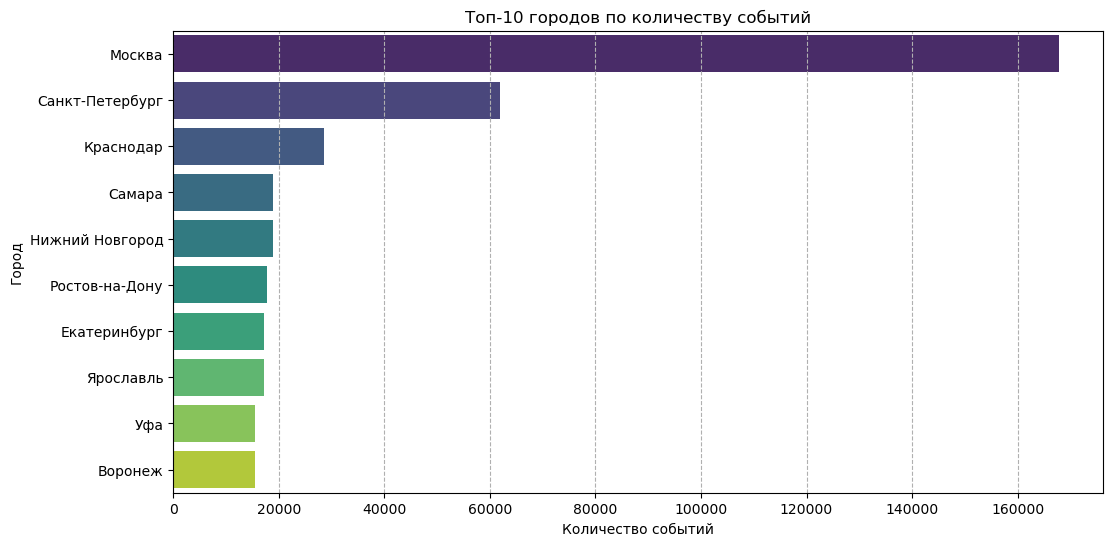

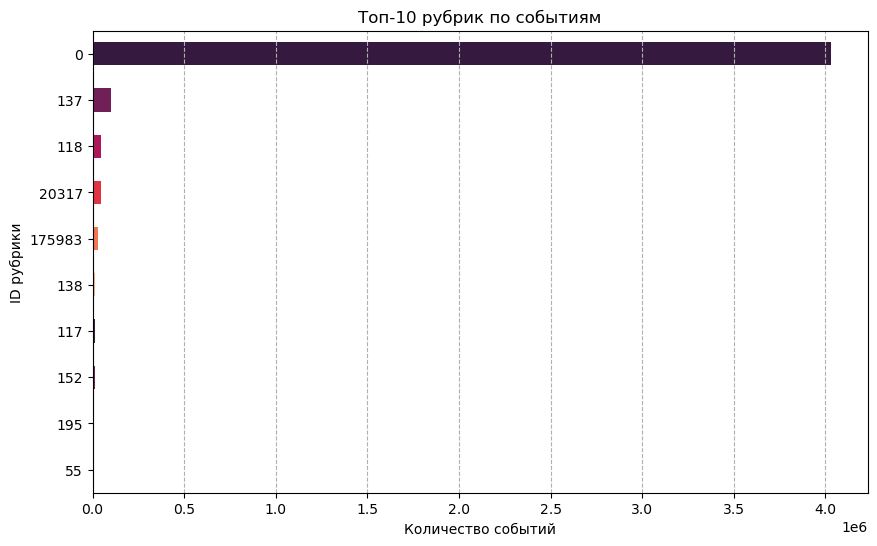

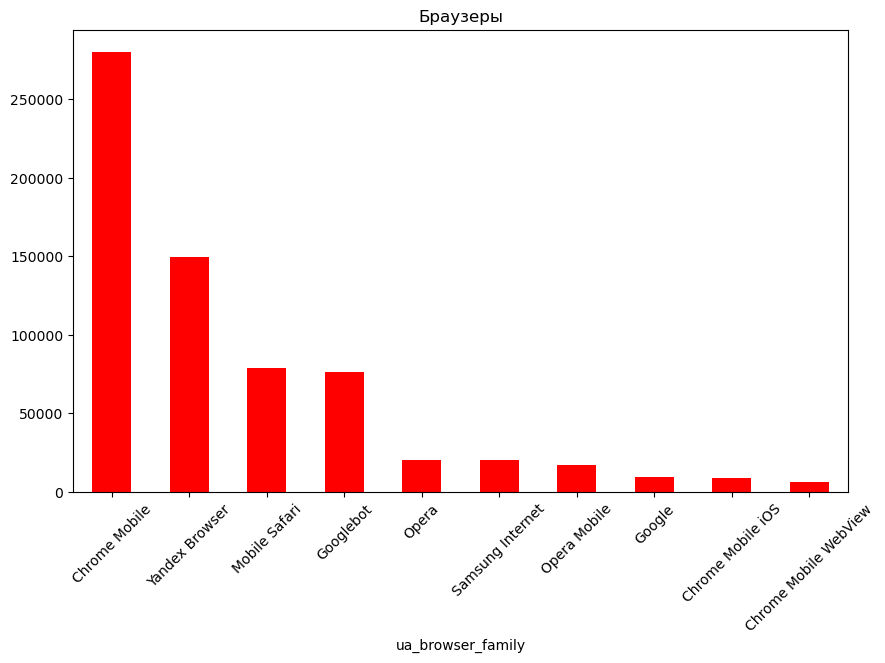

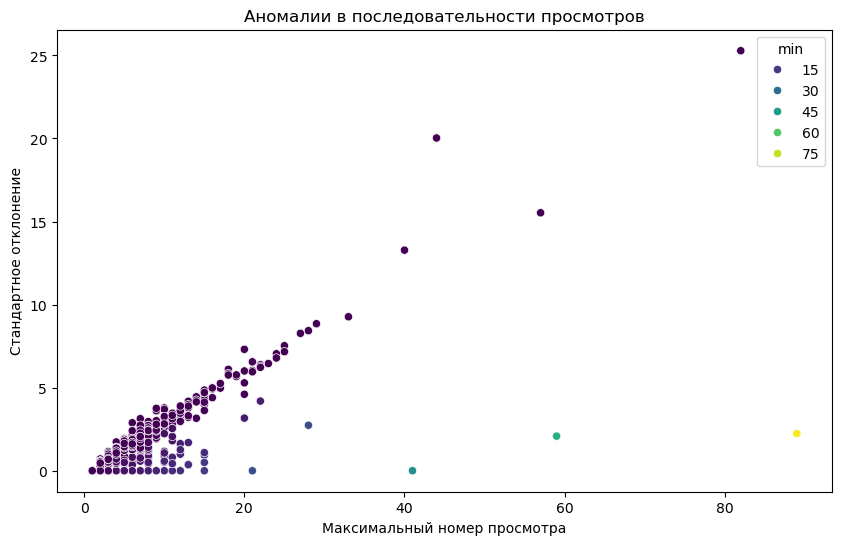

C:\Users\User\AppData\Local\Temp\ipykernel_13736\992442106.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


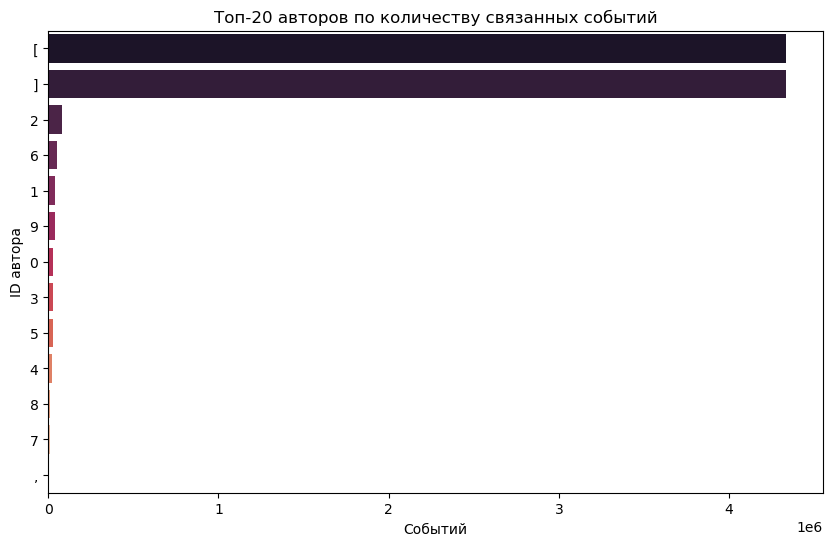

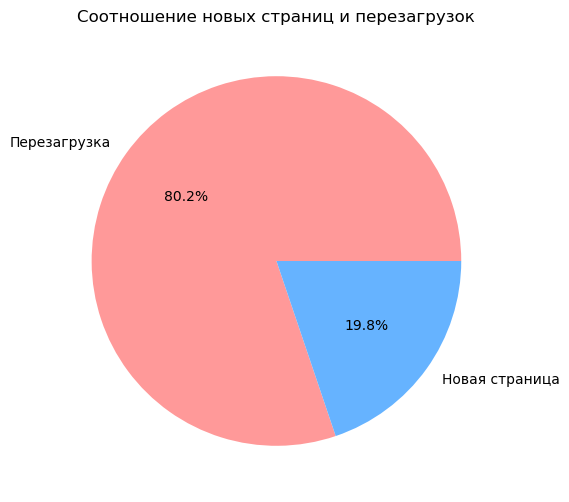

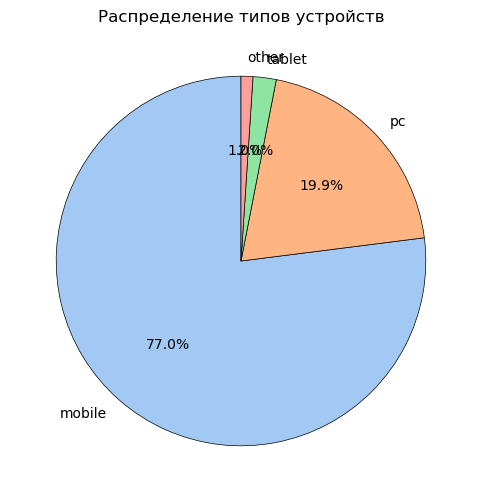

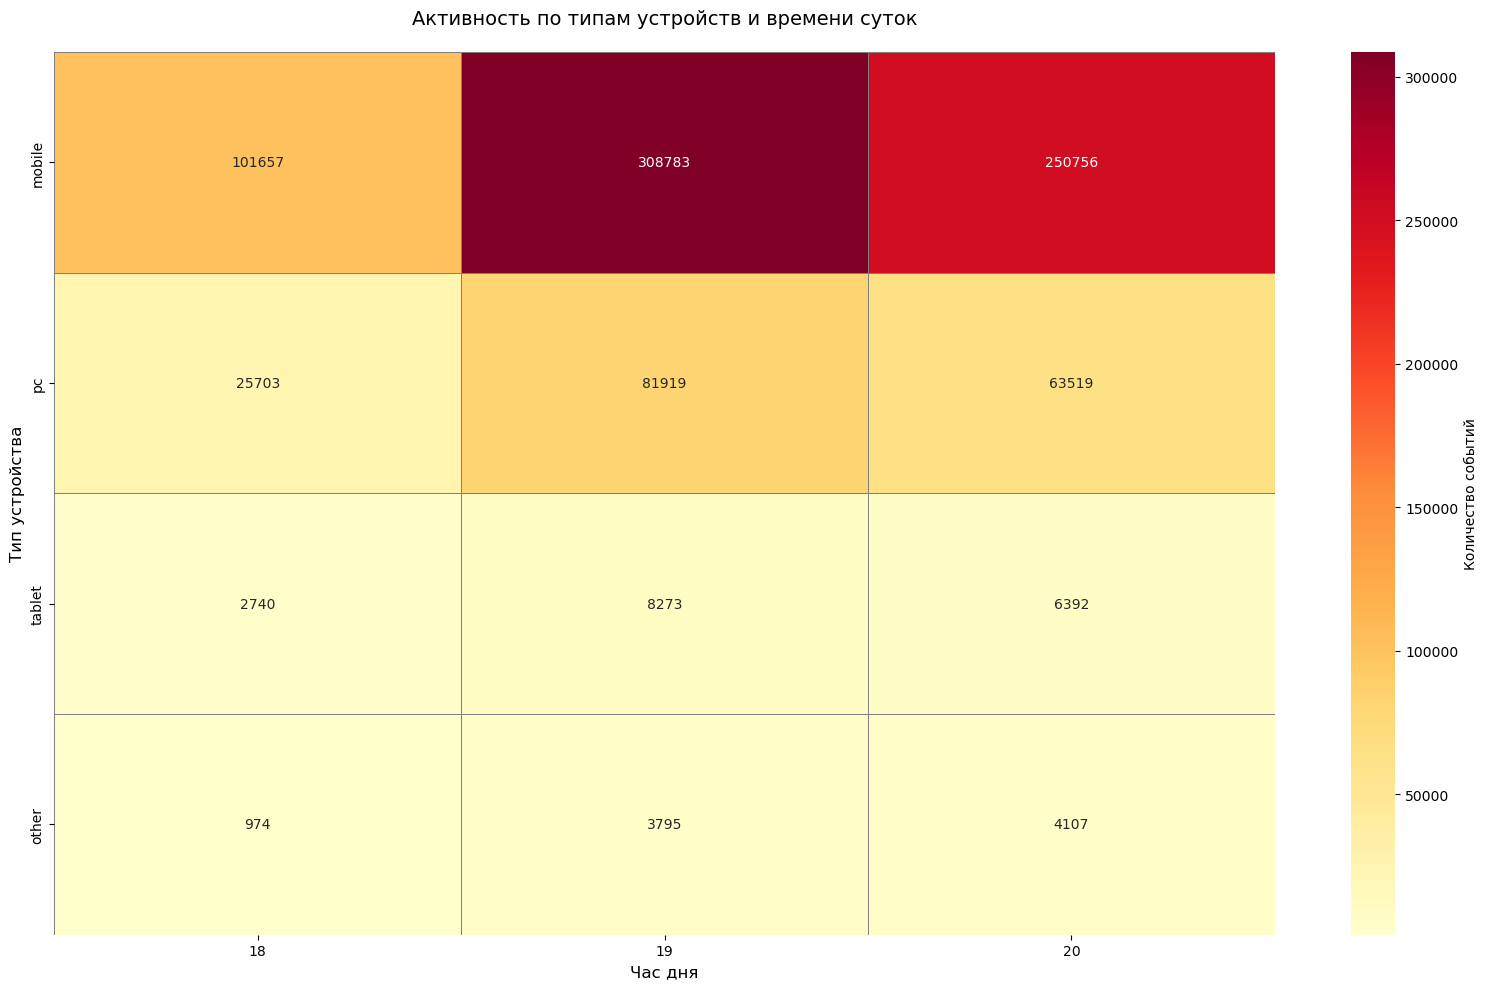

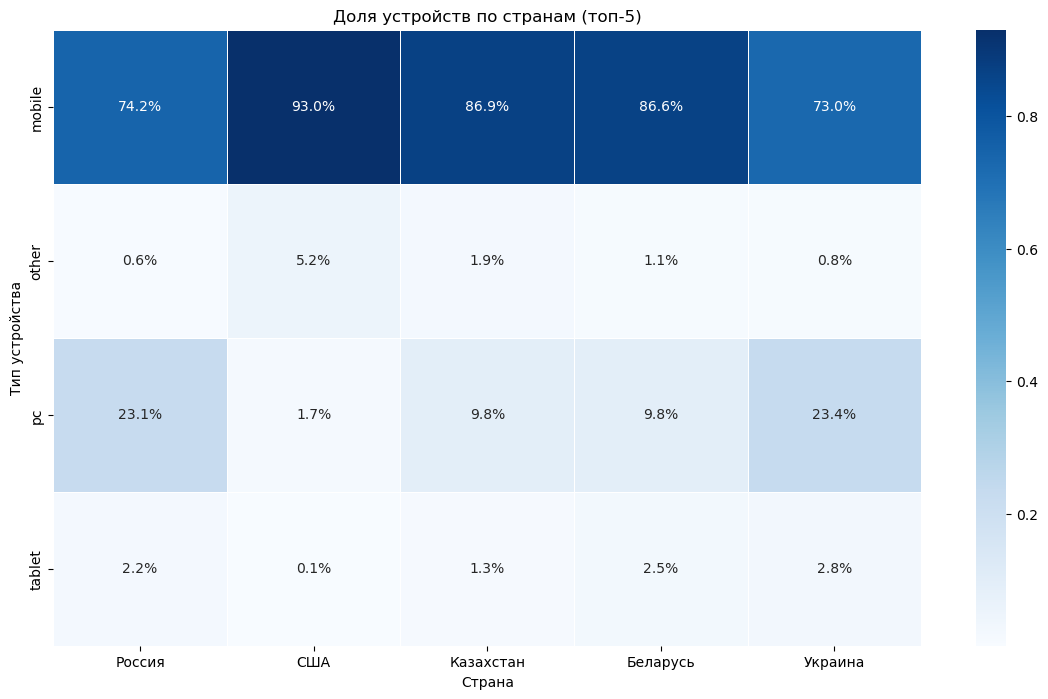

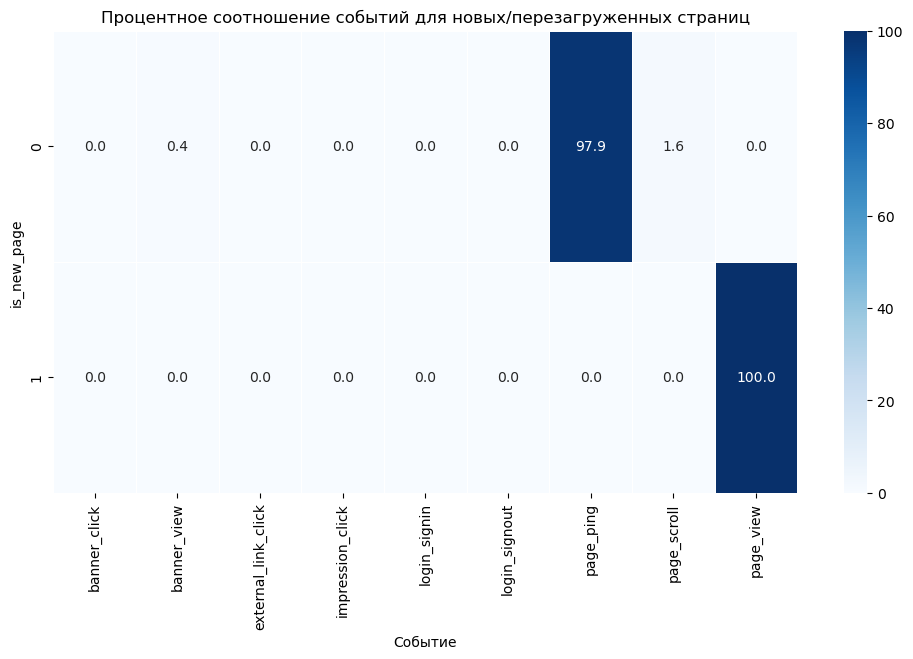

C:\Users\User\AppData\Local\Temp\ipykernel_13736\992442106.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


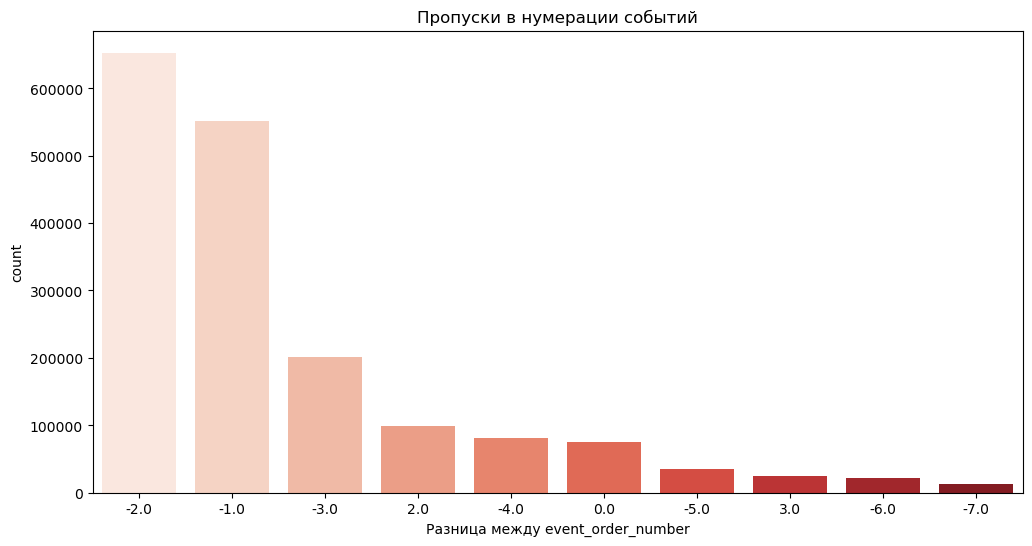

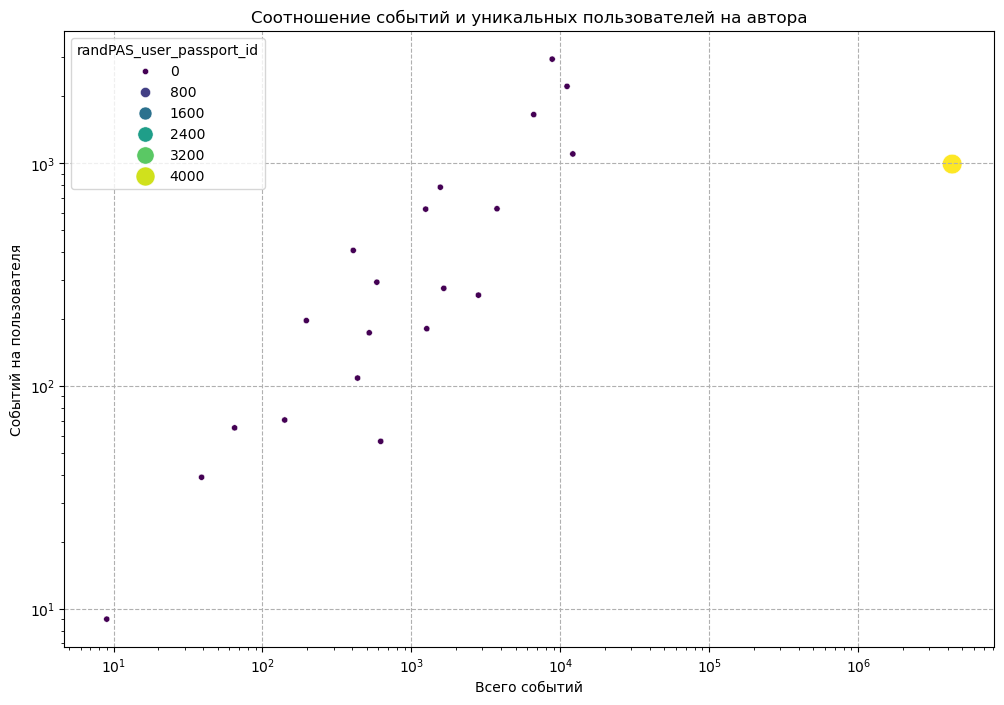

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\User\OneDrive\Desktop\dataset\dataset.csv")

df['ts'] = pd.to_datetime(df['ts'], errors='coerce')
df = df.dropna(subset=['ts'])  # Удаление некорректных дат
df['secs'] = pd.to_numeric(df['secs'], errors='coerce').fillna(0)
print("Количество строк после обработки:", len(df))



top_cities = df['geo_city_title_ru'].value_counts().head(10) #активность по городам
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.values, y=top_cities.index, palette='viridis')
plt.title('Топ-10 городов по количеству событий')
plt.xlabel('Количество событий')
plt.ylabel('Город')
plt.grid(axis='x', linestyle='--')
plt.show()

plt.figure(figsize=(10, 6))
df['main_rubric_id'].value_counts().head(10).plot(
    kind='barh',
    color=sns.color_palette('rocket')
)
plt.title('Топ-10 рубрик по событиям')
plt.xlabel('Количество событий')
plt.ylabel('ID рубрики')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--')
plt.show()

# Аномалии в user agents
session_length = df.groupby('randPAS_session_id')['ts'].agg(['min', 'max'])
session_length['duration'] = (session_length['max'] - session_length['min']).dt.total_seconds()
suspicious_browsers = df[~df['ua_browser_family'].isin(['Chrome', 'Firefox', 'Safari', 'Edge'])]
if not suspicious_browsers.empty:
    plt.figure(figsize=(10, 6))
    suspicious_browsers['ua_browser_family'].value_counts().head(10).plot(
        kind='bar',
        color='red'
    )
    plt.title('Браузеры')
    plt.xticks(rotation=45)
    plt.show()


# Аномалии в последовательности page_view_order_number
# сбросы нумерации просмотров
user_view_seq = df.groupby('randPAS_user_passport_id')['page_view_order_number'].agg(['min', 'max', 'std'])
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=user_view_seq['max'],
    y=user_view_seq['std'],
    hue=user_view_seq['min'],
    palette='viridis'
)
plt.title('Аномалии в последовательности просмотров')
plt.xlabel('Максимальный номер просмотра')
plt.ylabel('Стандартное отклонение')
plt.show()


# Аномалии в авторах контента
# авторs с подозрительной активностью
from itertools import chain
author_activity = pd.Series(chain(*df['content_author_ids'])).value_counts().head(20)
plt.figure(figsize=(10, 6)) #авторы с подозрительной активностью.
sns.barplot(
    x=author_activity.values,
    y=author_activity.index.astype(str),
    palette='rocket'
)
plt.title('Топ-20 авторов по количеству связанных событий')
plt.xlabel('Событий')
plt.ylabel('ID автора')
plt.show()


# Соотношение новых страниц и перезагрузок
plt.figure(figsize=(6, 6))
df['is_new_page'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Перезагрузка', 'Новая страница'],
    colors=['#ff9999','#66b3ff']
)
plt.title('Соотношение новых страниц и перезагрузок')
plt.ylabel('')
plt.show()


# Распределение типов устройств
plt.figure(figsize=(10, 6))
df['ua_device_type'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}
)
plt.title('Распределение типов устройств')
plt.ylabel('')
plt.show()

device_hour_activity = df.pivot_table(
    index='ua_device_type',
    columns=df['ts'].dt.hour,
    values='event',
    aggfunc='count',
    fill_value=0
)
#топ-10 устройств
top_devices = device_hour_activity.sum(axis=1).nlargest(10).index
device_hour_activity = device_hour_activity.loc[top_devices]

plt.figure(figsize=(16, 10))
sns.heatmap(
    device_hour_activity,
    cmap='YlOrRd',
    annot=True,
    fmt='d',
    linewidths=0.5,
    linecolor='grey',
    cbar_kws={'label': 'Количество событий'}
)

#  распределение событий по комбинации устройство + страна
plt.title('Активность по типам устройств и времени суток', fontsize=14, pad=20)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Тип устройства', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

device_country = df.groupby(['ua_device_type', 'geo_country_title_ru']).size().unstack()

# для топ-5 стран
top_countries = df['geo_country_title_ru'].value_counts().head(5).index
device_country = device_country[top_countries]
plt.figure(figsize=(14, 8))
sns.heatmap(
    device_country.apply(lambda x: x/x.sum(), axis=0),  # Нормировка по странам
    cmap='Blues',
    annot=True,
    fmt='.1%',
    linewidths=0.5
)
plt.title('Доля устройств по странам (топ-5)')
plt.xlabel('Страна')
plt.ylabel('Тип устройства')
plt.show()



# Взаимосвязь is_new_page и event
# странные комбинации событий
cross_tab = pd.crosstab(df['is_new_page'], df['event'], normalize='index') * 100
plt.figure(figsize=(12, 6))
sns.heatmap(
    cross_tab,
    annot=True,
    fmt='.1f',
    cmap='Blues',
    linewidths=0.5
)
plt.title('Процентное соотношение событий для новых/перезагруженных страниц')
plt.xlabel('Событие')
plt.ylabel('is_new_page')
plt.show()


 # Аномальные паттерны в event_order_number
 # сессии с нелогичным порядком событий
df['event_order_diff'] = df.groupby('randPAS_session_id')['event_order_number'].diff().fillna(1)
anomalous_diff = df[df['event_order_diff'] != 1]

if not anomalous_diff.empty:
    plt.figure(figsize=(12, 6))
    sns.countplot(
        x=anomalous_diff['event_order_diff'],
        order=anomalous_diff['event_order_diff'].value_counts().index[:10],
        palette='Reds'
    )
    plt.title('Пропуски в нумерации событий')
    plt.xlabel('Разница между event_order_number')
    plt.show()




#Аномальные паттерны авторов контента
# авторов с подозрительным распределением активности
author_stats = df.explode('content_author_ids').groupby('content_author_ids').agg({
    'event': 'count',
    'randPAS_user_passport_id': 'nunique'
}).reset_index()
author_stats['events_per_user'] = author_stats['event'] / author_stats['randPAS_user_passport_id']

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=author_stats['event'],
    y=author_stats['events_per_user'],
    size=author_stats['randPAS_user_passport_id'],
    hue=author_stats['randPAS_user_passport_id'],
    sizes=(20, 200),
    palette='viridis'
)
plt.title('Соотношение событий и уникальных пользователей на автора')
plt.xlabel('Всего событий')
plt.ylabel('Событий на пользователя')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, linestyle='--')
plt.show()